In [1]:
import warnings
warnings.filterwarnings("ignore")
from evaluation.mol_structure import list_of_smiles_to_nx_graphs,list_of_nx_graphs_to_smiles
from evaluation.mol_structure import draw_one_mol, draw_graphs
from evaluation.new_structural_metric import symmetric_graph_set_distance,atom,cycle,neighborhood
from evaluate import evaluate
#import utils.graph_generators as gen
import torch
import networkx as nx
import os 
import sys
import json
current = os.getcwd()
parent = os.path.dirname(current)
sys.path.append(parent)
import rdkit
import numpy as np
from evaluation.utils import get_data,  get_mock_data,remove_empty_graphs_and_targets,\
    get_generated_data,preprocess,get_graph_data, get_generated_graph_data
import rdkit
from rdkit import Chem
from rdkit.Chem.rdchem import ChiralType, BondType, BondDir
from rdkit.Chem.rdmolops import AddHs
from evaluation.atom_bond_encoder import  atom_to_feature_vector,bond_to_feature_vector
from evaluation.moses.metrics.metrics import get_all_metrics



#  Functions used

In [2]:
def rdkmol_to_nx(mol):
    #  rdkit-mol object to nx.graph
    graph = nx.Graph()
    for atom in mol.GetAtoms():
        graph.add_node(atom.GetIdx(), label=int(atom.GetAtomicNum()), attr=atom_to_feature_vector(atom) ,  label_name=atom.GetSymbol())
    for bond in mol.GetBonds():
        graph.add_edge(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(),label=(int(bond.GetBondTypeAsDouble())),
                       attr=bond_to_feature_vector(bond),
                       edge_label=str(bond.GetBondType()) )
    return graph

def smiles_to_mol(list_of_smiles):
    list_of_rdkit_mols=[]
    for _,smile in enumerate(list_of_smiles):
        try:
            mol = Chem.MolFromSmiles(smile)
            list_of_rdkit_mols.append(mol)
        except:list_of_rdkit_mols.append(Chem.MolFromSmiles('C'))
    return list_of_rdkit_mols
    



def nx_to_rdkit(graph):
    m = Chem.MolFromSmiles('')
    mw = Chem.RWMol(m)
    atom_index = {}
    for n, d in graph.nodes(data=True):
        atom_index[n] = mw.AddAtom(Chem.Atom(d['label']))
    for a, b, d in graph.edges(data=True):
        start = atom_index[a]
        end = atom_index[b] 
        bond_type=d['edge_label']
        try:
            mw.AddBond(start, end, eval("rdkit.Chem.rdchem.BondType.{}".format(bond_type)))
        except:
            mw.AddBond(start, end, eval("rdkit.Chem.rdchem.BondType.{}".format('SINGLE')))
            #print('exc',bond_type)
            continue
            raise Exception('bond type not implemented')

    mol = mw.GetMol()
    return mol

def list_of_smiles_to_nx_graphs(smiles):
    list_of_nx_graphs=[]
    for i,smile in enumerate(smiles):
        mol = Chem.MolFromSmiles(smile)
        if mol is not None:
           list_of_nx_graphs.append(rdkmol_to_nx(mol))
        else:
            continue
         
    return list_of_nx_graphs


def list_of_nx_graphs_to_smiles(graphs, file=None):
    # writes smiles strings to a file
    chem = [nx_to_rdkit(graph) for graph in graphs]
    smis = [Chem.MolToSmiles(m) for m in chem]
    if file:
        with open(file, 'w') as f:
            f.write('\n'.join(smis))
    return smis




# Smiles =>  Molecular graphs =>  Smiles

# Train1 vs Train1  before versus after graph conversion 

In [4]:
current_smiles_datasets=['ames', 'bbb_martins', 'cyp1a2_veith', 'cyp2c19_veith','herg_karim','lipophilicity_astrazeneca']
splits=['_50']
device=torch.device('cpu')
structural_statistic=['WL', 'nspdk','degree','cluster', 'spectral']#'common_substructures']

metrics_type=['molecular']
#leave it blank to compute all the structural structures 
metrics={}
metrics2={}
for generator in ['train1']:
    for dataset_name in current_smiles_datasets:
        for split in splits:
                print(dataset_name+split, generator)
                graphs,smiles  =get_data(dataset_name+split, return_smiles=True)
                train1_smiles_before_conversion=smiles['train1_pos_smiles']+ smiles['train1_neg_smiles']
                train1_graphs=list_of_smiles_to_nx_graphs(train1_smiles_before_conversion)
                train1_smiles=list_of_nx_graphs_to_smiles(train1_graphs)          
                print('Metrics before  coversion:')
                metrics=get_all_metrics(gen=train1_smiles_before_conversion,train=train1_smiles_before_conversion, test=train1_smiles_before_conversion)
                print(metrics)
                print('Metrics after  coversion:')
                try:
                  metrics2=get_all_metrics(gen=train1_smiles,train=train1_smiles,test=train1_smiles)
                  print(metrics2)
                except:
                     print('Error when computing the metrics for the converted graphs')
                     continue
                

ames_50 train1
Metrics before  coversion:
{'valid': 1.0, 'unique@1000': 0.999, 'unique@10000': 0.9996073812328229, 'FCD/Test': -3.552713678800501e-13, 'SNN/Test': 1.0, 'Frag/Test': 1, 'Scaf/Test': 1, 'FCD/TestSF': 22.270570164551017, 'SNN/TestSF': 0.33544746274439363, 'Frag/TestSF': -0.06553137100764106, 'Scaf/TestSF': 0.13905682249091533, 'IntDiv': 0.9105206593714188, 'IntDiv2': 0.8919648544524341, 'Filters': 0.5551629367883785, 'logP': 0.0, 'SA': 0.0, 'QED': 0.0, 'weight': 0.0, 'Novelty': 0.0015710919088766694}
Metrics after  coversion:
Error when computing the metrics for the converted graphs
bbb_martins_50 train1
Metrics before  coversion:
{'valid': 1.0, 'unique@1000': 0.9943661971830986, 'unique@10000': 0.9943661971830986, 'FCD/Test': -5.826450433232822e-13, 'SNN/Test': 1.0, 'Frag/Test': 1, 'Scaf/Test': 1, 'FCD/TestSF': 19.4438681661209, 'SNN/TestSF': 0.3730856233761764, 'Frag/TestSF': -0.10547896046759009, 'Scaf/TestSF': 0.024943099994351514, 'IntDiv': 0.8849596139292613, 'IntDiv

# Direct smiles evaluation  

In [ ]:
current_smiles_datasets=['ames', 'bbb_martins', 'cyp1a2_veith', 'cyp2c19_veith','herg_karim','lipophilicity_astrazeneca']
splits=['_25','_33','_40','_50']
device=torch.device('cpu')
structural_statistic=['WL', 'nspdk','degree','cluster', 'spectral']#'common_substructures']

metrics_type=['molecular']
#leave it blank to compute all the structural structures 
generators=['hiervae','wgan','stgg','moflow','gdss','jtnn','swingnn']
metrics={}
for generator in generators:
    for dataset_name in current_smiles_datasets:
        for split in splits:
        
                print(dataset_name+split, generator)
                graphs,smiles  =get_data(dataset_name+split, return_smiles=True)
                _, _, generated_smiles_before_conversion=get_generated_data(dataset_name+split,generator_name=generator, return_smiles=True)
                train1_smiles_before_conversion=smiles['train1_pos_smiles']+ smiles['train1_neg_smiles']
                train1_graphs=list_of_smiles_to_nx_graphs(train1_smiles_before_conversion)
                generated_graphs=list_of_smiles_to_nx_graphs(generated_smiles_before_conversion)
                train1_smiles=list_of_nx_graphs_to_smiles(train1_graphs)
                generated_smiles=list_of_nx_graphs_to_smiles(generated_graphs)
                
  
                metrics=get_all_metrics(gen=generated_smiles,train=train1_smiles)
                metrics['dataset']=dataset_name+split
                metrics['generator_name']=generator
                print(metrics)

In [19]:
from evaluation.moses.metrics.metrics import get_all_metrics
current_smiles_datasets=['ames', 'bbb_martins', 'cyp1a2_veith', 'cyp2c19_veith','herg_karim','lipophilicity_astrazeneca']
splits2=['_25','_33','_40','_50']
generators=['hiervae','wgan','stgg','moflow','gdss','jtnn','swingnn']
metrics={}
for generator in generators:
    for dataset_name in current_smiles_datasets:
        for split in splits2:
            try:
                print(dataset_name+split, generator)
                graphs, splits =get_data(dataset_name+split, return_smiles=True)
                train1_smiles=splits['train1_pos_smiles']+splits['train1_neg_smiles'] 
                _,_, generated_smiles=get_generated_data(dataset_name+split,generator_name=generator,return_smiles=True)
                metrics=get_all_metrics(gen=generated_smiles,train=train1_smiles)
                metrics['dataset']=dataset_name+split
                metrics['generator_name']=generator
                print(metrics)
            except: print('skipping',dataset_name+split,generator )


ames_25 hiervae


In [5]:
from evaluation.moses.metrics.metrics import get_all_metrics
current_smiles_datasets=[ 'cyp2c19_veith']

splits2=['_50']
generators=['moflow']
metrics={}
for generator in generators:
    for dataset_name in current_smiles_datasets:
        for split in splits2:
       
                print(dataset_name+split, generator)
                graphs, splits =get_data(dataset_name+split, return_smiles=True)
                train1_smiles=splits['train1_pos_smiles']+splits['train1_neg_smiles'] 
                _,_, generated_smiles=get_generated_data(dataset_name+split,generator_name=generator,return_smiles=True)
                metrics=get_all_metrics(gen=generated_smiles,train=train1_smiles,test=train1_smiles)
                metrics['dataset']=dataset_name+split
                metrics['generator_name']=generator
                print(metrics)


cyp2c19_veith_50 moflow
{'valid': 1.0, 'unique@1000': 0.97, 'unique@10000': 0.9398843930635838, 'FCD/Test': 43.248436351736586, 'SNN/Test': 0.17088936643448868, 'Frag/Test': 0.2790688518825144, 'Scaf/Test': nan, 'FCD/TestSF': 41.87841065178454, 'SNN/TestSF': 0.16461410985344407, 'Frag/TestSF': 0.6603249006054549, 'Scaf/TestSF': nan, 'IntDiv': 0.9124524837882134, 'IntDiv2': 0.8942235711822561, 'Filters': 0.20046242774566475, 'logP': 1.5311836774402188, 'SA': 2.307734549674342, 'QED': 0.26153900948175934, 'weight': 147.22643688834015, 'Novelty': 1.0, 'dataset': 'cyp2c19_veith_50', 'generator_name': 'moflow'}


In [ ]:
current_smiles_datasets=['ames', 'bbb_martins', 'cyp1a2_veith', 'cyp2c19_veith','herg_karim','lipophilicity_astrazeneca']
splits2=['_25','_33','_40','_50']
generators=['train1']
metrics={}
for generator in generators:
    for dataset_name in current_smiles_datasets:
        for split in splits2:
            print(dataset_name+split)
            graphs, splits =get_data(dataset_name+split, return_smiles=True)
            train1_smiles=splits['train1_pos_smiles']+splits['train1_neg_smiles'] 
            metrics=get_all_metrics(gen=train1_smiles,train=train1_smiles,test=train1_smiles)
            metrics['dataset']=dataset_name+split
            metrics['generator_name']=generator
            print(metrics)

In [2]:
current_smiles_datasets=['ames', 'bbb_martins', 'cyp1a2_veith', 'cyp2c19_veith','herg_karim','lipophilicity_astrazeneca']
splits2=['_25','_33','_40','_50']
generators=['train2']
metrics={}
for generator in generators:
    for dataset_name in current_smiles_datasets:
        for split in splits2:
            print(dataset_name+split)
            graphs, splits =get_data(dataset_name+split, return_smiles=True)
            train1_smiles=splits['train1_pos_smiles']+splits['train1_neg_smiles'] 
            train2_smiles=splits['train2_pos_smiles']+splits['train2_neg_smiles'] 
            metrics=get_all_metrics(gen=train2_smiles,train=train1_smiles,test=train1_smiles)
            metrics['dataset']=dataset_name+split
            metrics['generator_name']=generator
            print(metrics)

bbb_martins_25
{'valid': 1.0, 'unique@1000': 0.987, 'unique@10000': 0.9868667917448405, 'FCD/Test': nan, 'SNN/Test': 0.4450105435405395, 'Frag/Test': 0.9652945674793054, 'Scaf/Test': 0.5085105846511926, 'FCD/TestSF': 19.48097952918213, 'SNN/TestSF': 0.37320428054017935, 'Frag/TestSF': -0.014896269920706029, 'Scaf/TestSF': 0.01325809036969583, 'IntDiv': 0.8875475790522638, 'IntDiv2': 0.8725379596126854, 'Filters': 0.776735459662289, 'logP': 0.10707440031181478, 'SA': 0.07811260311719424, 'QED': 0.010851765333097079, 'weight': 16.219715191713142, 'Novelty': 0.9933460076045627, 'dataset': 'bbb_martins_25', 'generator_name': 'train2'}
bbb_martins_33
{'valid': 1.0, 'unique@1000': 0.989451476793249, 'unique@10000': 0.989451476793249, 'FCD/Test': 4.019596103748967, 'SNN/Test': 0.46147108480004195, 'Frag/Test': 0.9720934347020695, 'Scaf/Test': 0.5219050765936551, 'FCD/TestSF': 19.574541878846595, 'SNN/TestSF': 0.37471392010004584, 'Frag/TestSF': -0.015828951721364337, 'Scaf/TestSF': 0.03424493

KeyboardInterrupt: 

In [ ]:
current_smiles_datasets=['ames', 'bbb_martins', 'cyp1a2_veith', 'cyp2c19_veith','herg_karim','lipophilicity_astrazeneca']
splits2=['_25','_33','_40','_50']
generators=['train1/2+train2/2']
metrics={}
for generator in generators:
    for dataset_name in current_smiles_datasets:
            for split in splits2:
                print(dataset_name+split)
                graphs, splits =get_data(dataset_name+split, return_smiles=True)
                train1_smiles=splits['train1_pos_smiles']+splits['train1_neg_smiles'] 
                train2_smiles=splits['train2_pos_smiles']+splits['train2_neg_smiles'] 
                half=len(train1_smiles)//2
                train3_smiles=train1_smiles[:half] + train2_smiles[:half]
                metrics=get_all_metrics(gen=train3_smiles,train=train1_smiles,test=train1_smiles)
                metrics['dataset']=dataset_name+split
                metrics['generator_name']=generator
                print(metrics)

In [ ]:
structural_statistic=['WL', 'nspdk','degree','cluster', 'spectral']
device=torch.device('cpu')
metrics_type=['nn','structural', 'auc_roc']
generators=['swingnn','gdss']
splits=['_25','_33','_40','_50']
metrics={}
for generator in generators:
    for dataset_name in ['synthetic_1','synthetic_2']:
        for split in splits:
                print(dataset_name+split)
                train1_graphs,train1_targets,train2_graphs,train2_targets,test_graphs,test_targets=get_graph_data(dataset_name+split, path=r'data/graphs/datasets')
                generated_graphs, generated_targets= get_generated_graph_data(dataset_name+split,generator_name=generator)
                splits_for_auc_roc=[train1_graphs , train1_targets,train2_graphs , train2_targets, test_graphs, test_targets, generated_graphs, generated_targets]
                metrics=evaluate(train1_graphs, generated_graphs, device,  metrics_type, structural_statistic,*splits_for_auc_roc)
                metrics['dataset']=dataset_name+split
                metrics['generator_name']=generator
                print(metrics)

synthetic_1_25
Now computing classifier based metrics
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
Now computing structural based metrics
Cannot compute these structural metrics
Now computing the auc_roc based  metric


In [ ]:
structural_statistic=['WL', 'nspdk','degree','cluster', 'spectral']
device=torch.device('cpu')
metrics_type=['nn','structural', 'auc_roc']
generators=['train2']
splits=['_25','_33','_40','_50']
metrics={}
for generator in ['train2']:
    for dataset_name in ['synthetic_1','synthetic_2']:
        for split in splits:
            print(dataset_name+split)
            train1_graphs,train1_targets,train2_graphs,train2_targets,test_graphs,test_targets=get_graph_data(dataset_name+split, path=r'data/graphs/datasets')
            generated_graphs, generated_targets=train1_graphs,train1_targets
            splits_for_auc_roc=[train1_graphs , train1_targets,train2_graphs , train2_targets, test_graphs, test_targets, generated_graphs, generated_targets]
            metrics=evaluate(train1_graphs, generated_graphs, device,  metrics_type, structural_statistic,*splits_for_auc_roc)
            metrics['dataset']=dataset_name+split
            metrics['generator_name']=generator
            print(metrics)

In [ ]:
structural_statistic=['WL', 'nspdk','degree','cluster', 'spectral']
device=torch.device('cpu')
metrics_type=['nn','structural', 'auc_roc']
generators=['train2']
splits=['_25','_33','_40','_50']
metrics={}
for generator in ['train2']:
    for dataset_name in ['synthetic_1','synthetic_2']:
        for split in splits:
            print(dataset_name+split)
            train1_graphs,train1_targets,train2_graphs,train2_targets,test_graphs,test_targets=get_graph_data(dataset_name+split, path=r'data/graphs/datasets')
            generated_graphs, generated_targets=train2_graphs,train2_targets
            splits_for_auc_roc=[train1_graphs , train1_targets,train2_graphs , train2_targets, test_graphs, test_targets, generated_graphs, generated_targets]
            metrics=evaluate(train1_graphs, generated_graphs, device,  metrics_type, structural_statistic,*splits_for_auc_roc)
            metrics['dataset']=dataset_name+split
            metrics['generator_name']=generator
            print(metrics)


synthetic_1_25
Now computing classifier based metrics
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
Now computing structural based metrics
Now computing the auc_roc based  metric
0.7019 0.7620000000000001 0.7061000000000001 0.7620000000000001
{'activations_time': 0.09424567222595215, 'fid': 0.22577179982117457, 'fid_time': 0.09925174713134766, 'kid': 0.0009200573, 'kid_time': 48.37495970726013, 'precision': 0.985, 'recall': 0.99, 'f1_pr': 0.9875036709501676, 'precision_time': 0.1743147373199463, 'recall_time': 0.1743147373199463, 'f1_pr_time': 0.1743147373199463, 'density': 1.002, 'coverage': 0.98, 'f1_dc': 0.990887902342055, 'density_time': 0.15848922729492188, 'coverage_time': 0.15848922729492188, 'f1_dc_time': 0.15848922729492188, 'mmd_rbf': 0.009055978152900934, 'mmd_rbf_time': 0.200546026229858

In [ ]:
structural_statistic=['WL', 'nspdk','degree','cluster', 'spectral']
device=torch.device('cpu')
metrics_type=['nn','structural', 'auc_roc']
generators=['train2']
splits=['_25','_33','_40','_50']
metrics={}
for generator in ['train1/2+train2/2']:
    for dataset_name in ['synthetic_1','synthetic_2']:
        for split in splits:
            print(dataset_name+split)
            train1_graphs,train1_targets,train2_graphs,train2_targets,test_graphs,test_targets=get_graph_data(dataset_name+split, path=r'data/graphs/datasets')
            half=len(train1_graphs)//2
            half2=len(train2_graphs)//2
            train3_graphs,train3_targets=train1_graphs[:half]+train2_graphs[:half], train1_targets[:half]+train2_targets[:half]
            generated_graphs, generated_targets=train3_graphs,train3_targets
            splits_for_auc_roc=[train1_graphs , train1_targets,train2_graphs , train2_targets, test_graphs, test_targets, generated_graphs, generated_targets]
            metrics=evaluate(train1_graphs, generated_graphs, device,  metrics_type, structural_statistic,*splits_for_auc_roc)
            metrics['dataset']=dataset_name+split
            metrics['generator_name']=generator
            print(metrics)

synthetic_1_25
Now computing classifier based metrics
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
Now computing structural based metrics
Cannot compute these structural metrics
Now computing the auc_roc based  metric


# Data collection

## Hide

In [3]:
#disable  
from rdkit import RDLogger 
RDLogger.EnableLog('rdApp.*')
#RDLogger.DisableLog('rdApp.*')        
name='ames'                                                                                                                                                                                                                                                                                                                                                                                                                                                               
path='data/smiles/{}/train1_smiles.txt'.format(name)
#rom data.smiles.carcinogens import test_smiles
reference_smiles_list = []
with open(path) as my_file:
    for line in my_file:
        reference_smiles_list.append(line)
reference_nx_graphs=list_of_smiles_to_nx_graphs(reference_smiles_list)
"""
print(reference_smiles_list[0])
mol = Chem.MolFromSmiles(reference_smiles_list[0])
Chem.Kekulize(mol)
Chem.RemoveStereochemistry(mol)
Chem.rdmolops.AddHs(mol)
print(mol_to_smiles([mol])[0])
print(mol_to_smiles([nx_to_mol(reference_nx_graphs[0])])[0])
rdkit.Chem.Draw.MolToImage(mol = Chem.MolFromSmiles(reference_smiles_list[0]))
rdkit.Chem.Draw.MolToImage(mol = Chem.MolFromSmiles(mol_to_smiles([nx_to_mol(reference_nx_graphs[0])])[0]))

#rdkit.Chem.Draw.MolsToGridImage(mols = [Chem.MolFromSmiles(mol_to_smiles([nx_to_mol(reference_nx_graphs[0])])[0]),   Chem.MolFromSmiles(reference_smiles_list[0])  ]  )

#rdkit.Chem.Draw.MolsToGridImage(mols = [Chem.MolFromSmiles(mol_to_smiles([nx_to_mol(reference_nx_graphs[0])])[0]),   Chem.MolFromSmiles(reference_smiles_list[0])  ]  )
"""

'\nprint(reference_smiles_list[0])\nmol = Chem.MolFromSmiles(reference_smiles_list[0])\nChem.Kekulize(mol)\nChem.RemoveStereochemistry(mol)\nChem.rdmolops.AddHs(mol)\nprint(mol_to_smiles([mol])[0])\nprint(mol_to_smiles([nx_to_mol(reference_nx_graphs[0])])[0])\nrdkit.Chem.Draw.MolToImage(mol = Chem.MolFromSmiles(reference_smiles_list[0]))\nrdkit.Chem.Draw.MolToImage(mol = Chem.MolFromSmiles(mol_to_smiles([nx_to_mol(reference_nx_graphs[0])])[0]))\n\n#rdkit.Chem.Draw.MolsToGridImage(mols = [Chem.MolFromSmiles(mol_to_smiles([nx_to_mol(reference_nx_graphs[0])])[0]),   Chem.MolFromSmiles(reference_smiles_list[0])  ]  )\n\n#rdkit.Chem.Draw.MolsToGridImage(mols = [Chem.MolFromSmiles(mol_to_smiles([nx_to_mol(reference_nx_graphs[0])])[0]),   Chem.MolFromSmiles(reference_smiles_list[0])  ]  )\n'

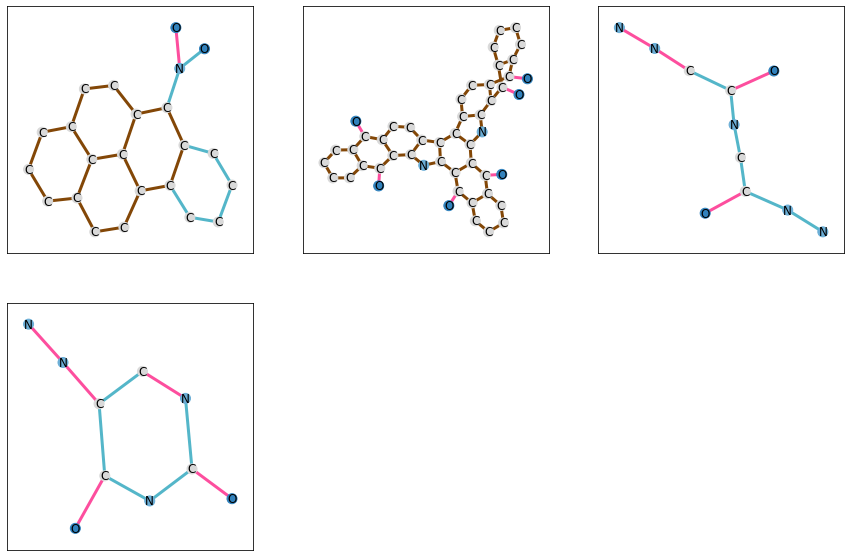

In [66]:
list_of_G=reference_nx_graphs[:4]
#for n , d in (G.nodes().items() ):
    #print(str(d['label'][0]))

draw_graphs(list_of_G)

[N-]=[N+]=CC(=O)NCC(=O)NN



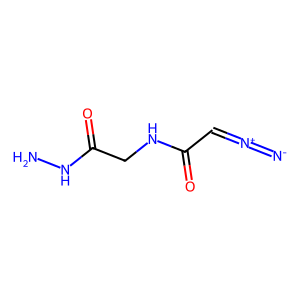

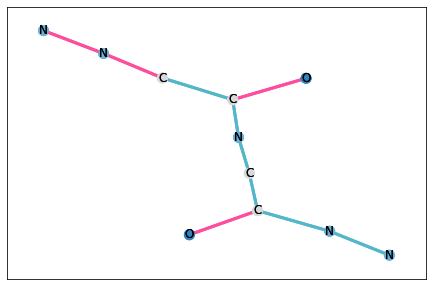

In [68]:
draw_one_mol(reference_nx_graphs[2])
print(reference_smiles_list[2])
draw_one_mol(reference_nx_graphs[2])

rdkit.Chem.Draw.MolToImage(mol = Chem.MolFromSmiles(reference_smiles_list[2]))


In [69]:
reference_nx_graphs[0].nodes(data=True)

NodeDataView({0: {'label': 8, 'attr': [7, 0, 1, 5, 0, 0, 1, 0, 0], 'label_name': 'O'}, 1: {'label': 7, 'attr': [6, 0, 3, 6, 0, 0, 1, 0, 0], 'label_name': 'N'}, 2: {'label': 8, 'attr': [7, 0, 1, 4, 0, 0, 1, 0, 0], 'label_name': 'O'}, 3: {'label': 6, 'attr': [5, 0, 3, 5, 0, 0, 1, 1, 1], 'label_name': 'C'}, 4: {'label': 6, 'attr': [5, 0, 3, 5, 0, 0, 1, 1, 1], 'label_name': 'C'}, 5: {'label': 6, 'attr': [5, 0, 3, 5, 0, 0, 1, 1, 1], 'label_name': 'C'}, 6: {'label': 6, 'attr': [5, 0, 3, 5, 0, 0, 1, 1, 1], 'label_name': 'C'}, 7: {'label': 6, 'attr': [5, 0, 3, 5, 1, 0, 1, 1, 1], 'label_name': 'C'}, 8: {'label': 6, 'attr': [5, 0, 3, 5, 1, 0, 1, 1, 1], 'label_name': 'C'}, 9: {'label': 6, 'attr': [5, 0, 3, 5, 0, 0, 1, 1, 1], 'label_name': 'C'}, 10: {'label': 6, 'attr': [5, 0, 3, 5, 1, 0, 1, 1, 1], 'label_name': 'C'}, 11: {'label': 6, 'attr': [5, 0, 3, 5, 1, 0, 1, 1, 1], 'label_name': 'C'}, 12: {'label': 6, 'attr': [5, 0, 3, 5, 1, 0, 1, 1, 1], 'label_name': 'C'}, 13: {'label': 6, 'attr': [5, 0, 3,

In [70]:
reference_nx_graphs[0].edges(data=True)

EdgeDataView([(0, 1, {'label': 2, 'attr': [1, 0, 1], 'edge_label': 'DOUBLE'}), (1, 2, {'label': 1, 'attr': [0, 0, 1], 'edge_label': 'SINGLE'}), (1, 3, {'label': 1, 'attr': [0, 0, 1], 'edge_label': 'SINGLE'}), (3, 4, {'label': 1, 'attr': [3, 0, 1], 'edge_label': 'AROMATIC'}), (3, 16, {'label': 1, 'attr': [3, 0, 1], 'edge_label': 'AROMATIC'}), (4, 5, {'label': 1, 'attr': [3, 0, 1], 'edge_label': 'AROMATIC'}), (4, 22, {'label': 1, 'attr': [0, 0, 0], 'edge_label': 'SINGLE'}), (5, 6, {'label': 1, 'attr': [3, 0, 1], 'edge_label': 'AROMATIC'}), (5, 19, {'label': 1, 'attr': [0, 0, 0], 'edge_label': 'SINGLE'}), (6, 7, {'label': 1, 'attr': [3, 0, 1], 'edge_label': 'AROMATIC'}), (6, 17, {'label': 1, 'attr': [3, 0, 1], 'edge_label': 'AROMATIC'}), (7, 8, {'label': 1, 'attr': [3, 0, 1], 'edge_label': 'AROMATIC'}), (8, 9, {'label': 1, 'attr': [3, 0, 1], 'edge_label': 'AROMATIC'}), (9, 10, {'label': 1, 'attr': [3, 0, 1], 'edge_label': 'AROMATIC'}), (9, 18, {'label': 1, 'attr': [3, 0, 1], 'edge_label':

## Show


In [3]:
current_smiles_datasets=['ames', 'bbb_martins', 'cyp1a2_veith', 'cyp2c19_veith','herg_karim','lipophilicity_astrazeneca']
splits=['_25','_33','_40','_50']
device=torch.device('cpu')
structural_statistic=['WL', 'nspdk','degree','cluster', 'spectral']#'common_substructures']
metrics_type=['nn', 'structural']#'molecular']
#leave it blank to compute all the structural structures 
generators=['hiervae','wgan','stgg','moflow','gdss','jtnn','swingnn']



In [4]:
device=torch.device('cpu')
metrics={}
for generator in generators:
    for dataset_name in current_smiles_datasets:
        for split in splits:
            print(dataset_name+split)
            train1_graphs , train1_targets,train2_graphs , train2_targets, test_graphs, test_targets  =get_data(dataset_name+split, return_smiles=False)
            generated_graphs, generated_targets=get_generated_data(dataset_name,generator_name=generator)
            splits_for_auc_roc=[train1_graphs , train1_targets,train2_graphs , train2_targets, test_graphs, test_targets, generated_graphs, generated_targets]
            metrics=evaluate(train1_graphs, generated_graphs, device,  metrics_type, structural_statistic,*splits_for_auc_roc)
            metrics['dataset']=dataset_name+split
            metrics['generator_name']=generator
            print(metrics)

ames_25
Now computing classifier based metrics
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
Now computing structural based metrics
{'activations_time': 0.4745817184448242, 'fid': 89.37352740009594, 'fid_time': 0.4916257858276367, 'kid': 5.7525334, 'kid_time': 41.67520999908447, 'precision': 0.9975980784627703, 'recall': 0.25216025137470544, 'f1_pr': 0.402578719623196, 'precision_time': 0.9364092350006104, 'recall_time': 0.9364092350006104, 'f1_pr_time': 0.9364092350006104, 'density': 0.9651721377101682, 'coverage': 0.13904163393558522, 'f1_dc': 0.24308286295937623, 'density_time': 0.6416990756988525, 'coverage_time': 0.6416990756988525, 'f1_dc_time': 0.6416990756988525, 'mmd_rbf': 0.484066367149353, 'mmd_rbf_time': 1.4535744190216064, 'mmd_linear': 66.20517, 'mmd_linear_time': 0.4745817184448242, '

In [3]:
device=torch.device('cpu')
metrics={}
for generator in ['train1']:
    for dataset_name in current_smiles_datasets:
        for split in splits:
            print(dataset_name+split)
            train1_graphs , train1_targets,train2_graphs , train2_targets, test_graphs, test_targets  =get_data(dataset_name+split, return_smiles=False)
            generated_graphs, generated_targets=train1_graphs,train1_targets
            splits_for_auc_roc=[train1_graphs , train1_targets,train2_graphs , train2_targets, test_graphs, test_targets, generated_graphs, generated_targets]
            metrics=evaluate(train1_graphs, generated_graphs, device,  metrics_type, structural_statistic,*splits_for_auc_roc)
            metrics['dataset']=dataset_name+split
            metrics['generator_name']=generator
            print(metrics)

ames_25
Now computing classifier based metrics
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
Now computing structural based metrics
{'activations_time': 0.09497904777526855, 'fid': -2.05708658995718e-08, 'fid_time': 0.10605001449584961, 'kid': -1.0951546, 'kid_time': 4.503940105438232, 'precision': 1.0, 'recall': 1.0, 'f1_pr': 1.00001, 'precision_time': 0.5347938537597656, 'recall_time': 0.5347938537597656, 'f1_pr_time': 0.5347938537597656, 'density': 1.2001571091908878, 'coverage': 1.0, 'f1_dc': 1.0909840901883978, 'density_time': 0.31894588470458984, 'coverage_time': 0.31894588470458984, 'f1_dc_time': 0.31894588470458984, 'mmd_rbf': 0, 'mmd_rbf_time': 0.5747997760772705, 'mmd_linear': 0.0, 'mmd_linear_time': 0.09510588645935059, 'wl_mmd': 0.0015710919088766694, 'wl_mmd_time': 1.1218819618225098, '

In [20]:
device=torch.device('cpu')
metrics={}
for generator in ['train2']:
    for dataset_name in current_smiles_datasets:
        for split in splits:
            print(dataset_name+split)
            train1_graphs , train1_targets,train2_graphs , train2_targets, test_graphs, test_targets  =get_data(dataset_name+split, return_smiles=False)
            generated_graphs, generated_targets=train2_graphs,train2_targets
            splits_for_auc_roc=[train1_graphs , train1_targets,train2_graphs , train2_targets, test_graphs, test_targets, generated_graphs, generated_targets]
            metrics=evaluate(train1_graphs, generated_graphs, device,  metrics_type, structural_statistic,*splits_for_auc_roc)
            metrics['dataset']=dataset_name+split
            metrics['generator_name']=generator
            print(metrics)

ames_25
Now computing classifier based metrics
Now computing structural based metrics
{'activations_time': 0.10030484199523926, 'fid': 4.865800534791404, 'fid_time': 0.10283994674682617, 'kid': 0.19350207, 'kid_time': 0.1501750946044922, 'precision': 0.9685781618224666, 'recall': 0.9732914375490966, 'f1_pr': 0.9709390797498794, 'precision_time': 0.2710459232330322, 'recall_time': 0.2710459232330322, 'f1_pr_time': 0.2710459232330322, 'density': 0.9538098978790259, 'coverage': 0.9536527886881383, 'f1_dc': 0.9537413368134584, 'density_time': 0.20402002334594727, 'coverage_time': 0.20402002334594727, 'f1_dc_time': 0.20402002334594727, 'mmd_rbf': 0.001806885004043579, 'mmd_rbf_time': 0.40337681770324707, 'mmd_linear': 0.103768684, 'mmd_linear_time': 0.10039353370666504, 'wl_mmd': 0.0015710919088766694, 'wl_mmd_time': 1.1708450317382812, 'nspdk_mmd': 0.0014388091537828052, 'nspdk_mmd_time': 7.240663766860962, 'degree_mmd': 0.00026359444890333705, 'degree_mmd_time': 13.983711, 'cluster_mmd': 

In [ ]:
device=torch.device('cpu')
metrics={}
for generator in ['train1/2+train2/2']:
    for dataset_name in current_smiles_datasets:
        for split in splits:
            print(dataset_name+split)
            train1_graphs , train1_targets,train2_graphs , train2_targets, test_graphs, test_targets  =get_data(dataset_name+split, return_smiles=False)
            half=len(train1_graphs)//2
            half2=len(train2_graphs)//2
            train3_graphs,train3_targets=train1_graphs[:half]+train2_graphs[:half], train1_targets[:half]+train2_targets[:half]
            generated_graphs, generated_targets=train3_graphs,train3_targets
            splits_for_auc_roc=[train1_graphs , train1_targets,train2_graphs , train2_targets, test_graphs, test_targets, generated_graphs, generated_targets]
            metrics=evaluate(train1_graphs, generated_graphs, device,  metrics_type, structural_statistic,*splits_for_auc_roc)
            metrics['dataset']=dataset_name+split
            metrics['generator_name']=generator
            print(metrics)